In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import nibabel as nib
from scipy import ndimage
from sklearn import preprocessing
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Add, Rescaling , Multiply, SeparableConv2D, Conv2D, Conv1D, Subtract, Conv2DTranspose, UpSampling2D, Dropout, BatchNormalization, Dense, Activation, concatenate, PReLU , UpSampling2D, GlobalAveragePooling2D, AveragePooling2D, Lambda, Concatenate, LeakyReLU, Reshape, Permute,PReLU, Flatten, MaxPooling2D
import tensorflow.keras.backend as K
import os
import cv2
from tqdm import tqdm
import gc
from keras_unet_collection import models

In [2]:
from tensorflow.keras import mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
Train_Image = "SEGMENTATION DATASET IMAGES 2/Train/Images/"
Train_Mask = "SEGMENTATION DATASET IMAGES 2/Train/Masks/"
Valid_Image = "SEGMENTATION DATASET IMAGES 2/Valid/Images/"
Valid_Mask = "SEGMENTATION DATASET IMAGES 2/Valid/Masks/"

In [4]:
def preprocess(image):
  return image/255.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rotation_range=60,
#                                    horizontal_flip = True, vertical_flip = True
#                                    , preprocessing_function=preprocess)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess)
seed = 1000
batch_size = 32
train_image_generator = train_datagen.flow_from_directory(Train_Image, seed=seed, batch_size= batch_size, shuffle = True,  class_mode = None)

train_mask_generator = train_datagen.flow_from_directory(Train_Mask, seed=seed, batch_size = batch_size, shuffle = True, color_mode = "grayscale", class_mode = None)

train_generator = zip(train_image_generator, train_mask_generator)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess)

val_image_generator = valid_datagen.flow_from_directory(Valid_Image, batch_size= 767, shuffle = False)

val_mask_generator = valid_datagen.flow_from_directory(Valid_Mask, batch_size = 767, shuffle = False, color_mode = "grayscale")

val_generator = zip(val_image_generator, val_mask_generator)

Found 2234 images belonging to 1 classes.
Found 2234 images belonging to 1 classes.
Found 559 images belonging to 1 classes.
Found 559 images belonging to 1 classes.


In [5]:
Valid_Images,Valid_Masks = next(val_generator)
Valid_Images = Valid_Images[0]
Valid_Masks = Valid_Masks[0]


In [6]:
import random

def jaccard_score(y_true, y_pred, smooth=1e-6):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    axis = -1
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    intersection = K.sum(K.abs(y_true * y_pred), axis=axis)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=axis)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


def jaccard_distance (y_true, y_pred, smooth=1):
    return 1 - jaccard_score(y_true, y_pred, smooth=1e-6) * smooth

# def dice_coef(y_true, y_pred, smooth=1e-6):
#     """
#     Dice = (2*|X & Y|)/ (|X|+ |Y|)
#          =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
#     ref: https://arxiv.org/pdf/1606.04797v1.pdf
#     """
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = -1
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)



ALPHA = 0.3
BETA = 0.7
GAMMA = 1

def FocalTverskyLoss(y_true, y_pred, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):
    
        #flatten label and prediction tensors
        y_pred = K.flatten(y_pred)
        y_true = K.flatten(y_true)
        axis = -1
        #True Positives, False Positives & False Negatives
        TP = K.sum(y_true * y_pred, axis=axis)
        FP = K.sum(y_true * (1-y_pred), axis=axis)
        FN = K.sum((1-y_true) * y_pred, axis=axis)
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky


def Tversky (y_true, y_pred, smooth=1e-6):
            #flatten label and prediction tensors
        alpha = .3
        beta = 1 - alpha 
        y_pred = K.flatten(y_pred)
        y_true = K.flatten(y_true)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((y_pred * y_true))
        FP = K.sum(((1-y_true) * y_pred))
        FN = K.sum((y_true * (1-y_pred)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        return Tversky
    
def Tversky_loss (y_true, y_pred, smooth=1e-6):
    return 1 - Tversky (y_true, y_pred, smooth)

def Tversky_crossentropy(y_true, y_pred):
    Tversky = K.pow(Tversky_loss(y_true, y_pred),3/4)
    crossentropy = K.binary_crossentropy(y_true, y_pred)
    crossentropy = K.mean(crossentropy)
    
    return Tversky + crossentropy
def DiceBCELoss(y_true, y_pred, smooth=1e-6):    
       
    #flatten label and prediction tensors
    #y_pred = K.flatten(y_pred)
    #y_true = K.flatten(y_true)
    
    BCE =  K.binary_crossentropy(y_true, y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=(0,1,2,3))  
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE




def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow tensor
    :param y_pred: TensorFlow tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))


def binary_recall_specificity(y_true, y_pred, recall_weight, spec_weight):
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TN = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    FP = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    FN = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    # Converted as Keras Tensors


    specificity = TN / (TN + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())

    return 1.0 - (recall_weight*recall + spec_weight*specificity)

def custom_loss(recall_weight, spec_weight):

    def recall_spec_loss(y_true, y_pred):
        return binary_recall_specificity(y_true, y_pred, recall_weight, spec_weight)

    # Returns the (y_true, y_pred) loss function
    return recall_spec_loss


def mix_loss(y_true, y_pred):
    FTC = FocalTverskyLoss(y_true, y_pred)
    DCB = DiceBCELoss(y_true, y_pred)
    return FTC + DCB 

In [7]:
# weight: weighted tensor(same shape with mask image)
def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1e-6
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
            y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + \
    weighted_dice_loss(y_true, y_pred, weight)
    return loss



def SSIM (y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val = 1.0) 

def SSIM_LOSS (y_true, y_pred):
    return (1 - SSIM(y_true,y_pred))


def f1_score(y_true, y_pred):
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TN = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    FP = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    FN = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    # Converted as Keras Tensors


    return (TP/(TP+(0.5 * (FP+FN))))

from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).reshape(y_true.shape).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

def Combo_loss(targets, inputs, eps=1e-9):
        ALPHA = 0.5# < 0.5 penalises FP more, > 0.5 penalises FN         more
        CE_RATIO = 0.5 #weighted contribution of modified CE loss compared to Dice loss
        smooth = 1
        targets = K.flatten(targets)
        inputs = K.flatten(inputs)
                
        intersection = K.sum(targets * inputs)
        dice = (2. * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
        inputs = K.clip(inputs, eps, 1.0 - eps)
        out = - (ALPHA * ((targets * K.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * K.log(1.0 - inputs))))
        weighted_ce = K.mean(out, axis=-1)
        combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
                          
def wasserstein_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return K.mean(y_true * y_pred) 



def log_cosh_dice(y_true, y_pred):
    x = dice_coef_loss(y_true, y_pred)
    cosh_x = (K.exp(x) + K.exp(-x))/2
    loss = K.log(cosh_x)
    return loss

def mix_loss(y_true, y_pred):
    FTC = Tversky_crossentropy(y_true, y_pred)
    SSIM = SSIM_LOSS(y_true, y_pred)
    SL = surface_loss_keras(y_true, y_pred)
    return  FTC + SL * .1 + SSIM * 1.5

In [8]:
def get_model():
    model = models.unet_2d((None, None, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')
    return model

In [9]:
model = get_model()
model.compile(optimizer="adam", loss= FocalTverskyLoss,  metrics = ["accuracy",dice_coef, jaccard_score,
                                                                       tf.keras.metrics.Precision(),tf.keras.metrics.Recall() ])

model.summary()
lr = 1e-3
K.set_value(model.optimizer.lr,lr)

c:\users\boude\appdata\local\programs\python\python38\lib\site-packages\keras_unet_collection\_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


Model: "attunet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 VGG16_backbone (Functional)    [(None, None, None,  14714688    ['input_1[0][0]']                
                                 64),                                                             
                                 (None, None, None,                                               
                                 128),                                                            
                                 (None, None, None,                                   

 0_bn (BatchNormalization)      256)                             [0][0]']                         
                                                                                                  
 attunet_up1_conv_after_concat_  (None, None, None,   0          ['attunet_up1_conv_after_concat_0
 0_activation (ReLU)            256)                             _bn[0][0]']                      
                                                                                                  
 attunet_up1_conv_after_concat_  (None, None, None,   589824     ['attunet_up1_conv_after_concat_0
 1 (Conv2D)                     256)                             _activation[0][0]']              
                                                                                                  
 attunet_up1_conv_after_concat_  (None, None, None,   1024       ['attunet_up1_conv_after_concat_1
 1_bn (BatchNormalization)      256)                             [0][0]']                         
          

 0_activation (ReLU)            64)                              _bn[0][0]']                      
                                                                                                  
 attunet_up3_conv_after_concat_  (None, None, None,   36864      ['attunet_up3_conv_after_concat_0
 1 (Conv2D)                     64)                              _activation[0][0]']              
                                                                                                  
 attunet_up3_conv_after_concat_  (None, None, None,   256        ['attunet_up3_conv_after_concat_1
 1_bn (BatchNormalization)      64)                              [0][0]']                         
                                                                                                  
 attunet_up3_conv_after_concat_  (None, None, None,   0          ['attunet_up3_conv_after_concat_1
 1_activation (ReLU)            64)                              _bn[0][0]']                      
          

In [10]:
import gc
gc.collect()

341

In [11]:
import matplotlib.pyplot as plt
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples = None):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='gray')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1, cmap='gray')
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

In [14]:
K.clear_session()
tf.compat.v1.reset_default_graph()
gc.collect()

3436

In [17]:
model.load_weights("Segmentation GAN WEIGHTS/2D/UNET/UNET_2D.h5")
val = model.evaluate(Valid_Images, Valid_Masks, batch_size = 16, verbose = 1)

35/35 [==============================] - 4s 119ms/step - loss: 0.2721 - accuracy: 0.9767 - dice_coef: 0.6951 - jaccard_score: 0.5376 - precision: 0.8608 - recall: 0.5315


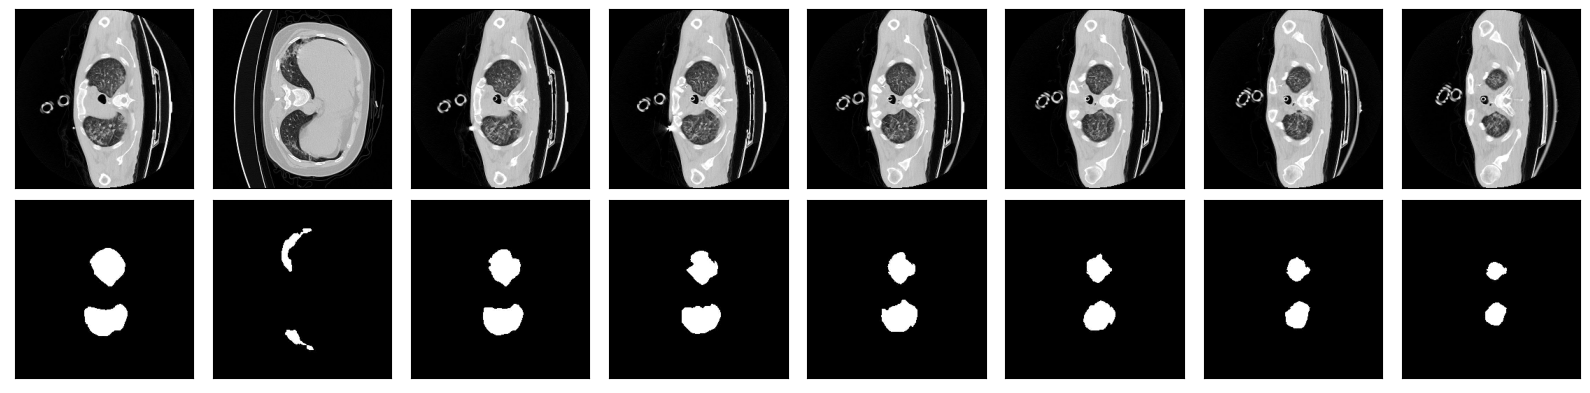

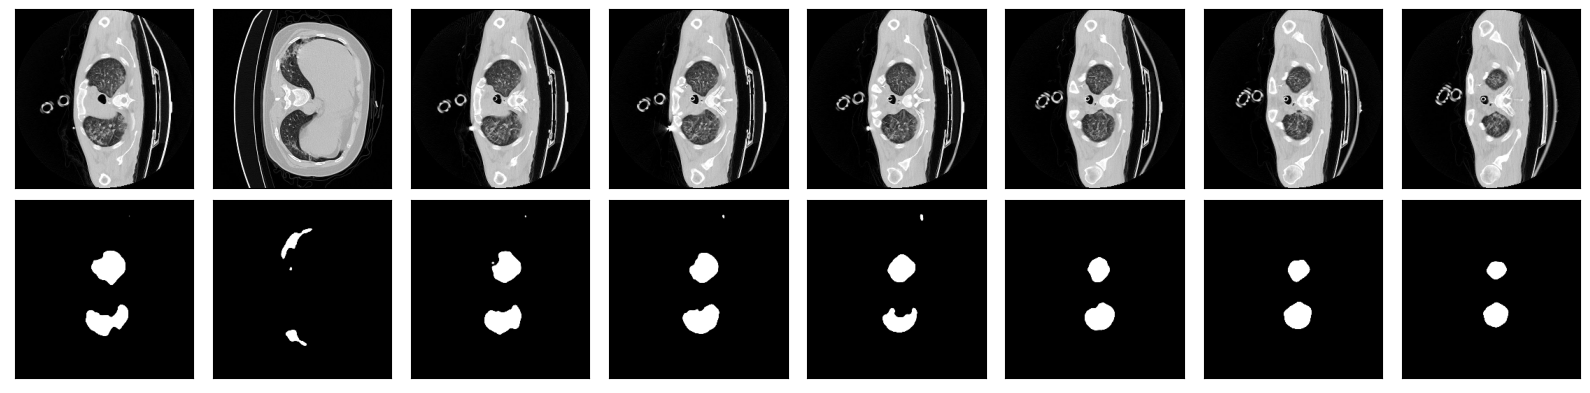

In [18]:
x, y = Valid_Images[300:308], Valid_Masks[300:308]
preds = model.predict_on_batch(x)
visualize(x,y, num_samples=8)

visualize(x,preds, num_samples=8)

In [ ]:

os._exit(00)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "Segmentation GAN WEIGHTS/2D/UNET_2D.h5", monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch')


In [ ]:
TB = tf.keras.callbacks.TensorBoard(
    log_dir='logs_UNET_2D',
    histogram_freq=1,
    write_graph=False,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=25,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=1)
batch_size = 64
history = model.fit(train_generator, verbose = 1, epochs = 150,
          validation_data = [Valid_Images, Valid_Masks] , callbacks = [checkpoint,reduce_lr,tf.keras.callbacks.TerminateOnNaN(), early_stopping, TB],
          steps_per_epoch = (2026//batch_size), initial_epoch = 0)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plt.plot(history.history['Tversky'])
# plt.plot(history.history['val_Tversky'])
# plt.title('model tversky')
# plt.ylabel('Tversky')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:

model.load_weights("Segmentation GAN WEIGHTS/2D/UNET_2D.h5")
val = model.evaluate(Valid_Images, Valid_Masks, batch_size = 32, verbose = 1)
import os
os._exit(00)

In [ ]:
from tqdm.notebook import tqdm
import random
import time
h = 256
w = 256
c = 1
J=0
lr = 1e-3
min_loss = val[0]
K.set_value(generator.optimizer.lr, lr)
K.set_value(discriminator.optimizer.lr, lr)
K.set_value(adversarial_model.optimizer.lr, lr)
epochs = 50
batch_size = 8
steps_per_epoch = 100
#validation_steps = 4
for epoch in range(epochs):
        print('Epoch ({}/{})-------------------------------------------------'.format(epoch,epochs))

        for i in tqdm(range(steps_per_epoch)):
        #              batch_x = np.array([next(train_image_generator) for i in range(batch_size)]).reshape(batch_size,target_x, target_y,3)
        #     batch_y = np.array([next(train_mask_generator) for i in range(batch_size)]).reshape(batch_size,target_x, target_y,1)
        #     """
            x_train,y_train = next(train_generator)
#             x_train = get_patches(x_train,h,w,ph,pw,c).reshape(-1,ph,pw,c)
#             y_train = get_patches(y_train,h,w,ph,pw,c).reshape(-1,ph,pw,c)
            
#             x_train,y_train = remove_black_images(x_train,y_train, 0)
            gc.collect()    
         
            
            ones = np.ones((y_train.shape[0], 1)) - np.random.uniform(0.001, 0.1)
            zeros = np.zeros((y_train.shape[0], 1)) + np.random.uniform(0.001, 0.1)
            dis_y_data = [ones,zeros]
            dis_y_data = np.array(dis_y_data).reshape(-1,1)
            discriminator.trainable = True
            Encoder.trainable = False
            batch_fake_images = generator.predict_on_batch(x_train)
            batch_fake_images = batch_fake_images.reshape(-1,h,w,c)
            dis_x_data1 = np.concatenate((x_train,x_train), axis = 0)
            dis_x_data2 = np.concatenate((y_train,batch_fake_images), axis = 0)

            discriminator.train_on_batch([dis_x_data1,dis_x_data2], dis_y_data)

            gc.collect()      
            del batch_fake_images
            del dis_x_data1
            del dis_x_data2
            del dis_y_data
            discriminator.trainable = False
            Encoder.trainable = True
            
            adversarial_model.train_on_batch(x_train, [y_train,ones])  
        val = generator.evaluate(Valid_Images, Valid_Masks, batch_size = 32, verbose = 1)

        l = val[0]
        if (l <= min_loss):
            print("val_loss progressed to: ", val)
            min_loss = l
            generator.save_weights("Segmentation GAN WEIGHTS/2D/gen_UNET_NRC_HEAVY.h5")
            discriminator.save_weights("Segmentation GAN WEIGHTS/2D/dis_UNET_NRC_HEAVY.h5")
            J=0
        
#                 generator.load_weights("{}/gen_UNET_NRC2D_COVID_{}_{} P_ {} R.h5".format(directory,Version, best_precision, best_recall))
#                 discriminator.load_weights("{}/dis_UNET_NRC2D_COVID_{}_{} P_ {} R.h5".format(directory, Version, best_precision, best_recall))
        else: 
            J+=1
            if J == 10:
                lr = lr*0.5
                K.set_value(generator.optimizer.lr, lr)
                K.set_value(discriminator.optimizer.lr, lr)
                K.set_value(adversarial_model.optimizer.lr, lr)
                J=0
                print("lr reduced to: ", lr)
#                 generator.load_weights("{}/gen_UNET_NRC2D_COVID_{}_{} P_ {} R.h5".format(directory,Version, best_precision, best_recall))
#                 discriminator.load_weights("{}/dis_UNET_NRC2D_COVID_{}_{} P_ {} R.h5".format(directory, Version, best_precision, best_recall))
        x, y = Valid_Images[300:307], Valid_Masks[300:307]
        preds = adversarial_model.predict_on_batch(x)[0]
        visualize(x,y, pred_batch = preds, num_samples=7)
